## Test functions for functions.py

### Task 14.1: count_nuclei for single fov

In [3]:
# import packages
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
#import napari_segment_blobs_and_things_with_membranes as nsbatwm
import os
import pandas as pd
from scipy import ndimage as ndi
import skimage as ski
from skimage import io

import functions as fct

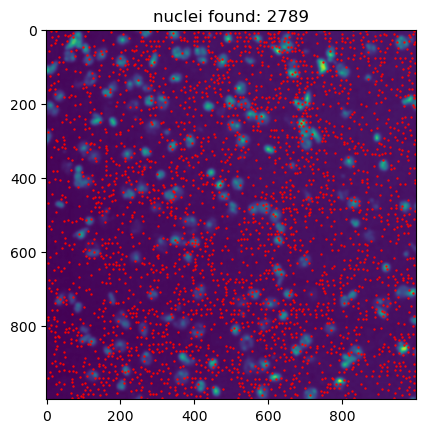

2789

In [3]:
def count_nuclei_v1(image):
## try counting local maxima
## did not work well, too many false positives in background
    img = io.imread(image)
    img = ski.filters.gaussian(img, sigma=2.8, preserve_range=True)     # Gaussian Blur reduces number of false positives

    # get coordinates of local maxima
    coords = ski.feature.peak_local_max(img, threshold_abs=5)           # get coordinates of local maxima
                                                                        # increasing the threshold_abs reduces number of false positives,
                                                                        # but also removes true positives

    # draw coordinates in plot
    plt.imshow(img)
    plt.scatter(coords[:,0], coords[:,1], s=2, c='red', marker='.')     # overlay coordinates on img
    plt.title('nuclei found: ' + str(len(coords)))
    plt.show()

    # return results
    return len(coords)                                                  # return number of local maxima

# call function
count_nuclei_v1('../data/selected-tiles/selected-tiles/out_opt_flow_registered_X10_Y10_c04_DAPI.tif')

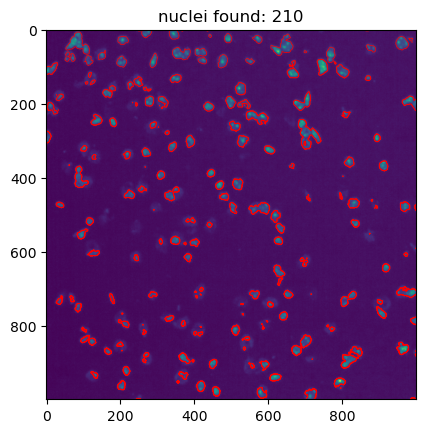

210

In [4]:
def count_nuclei_v2(image):
## segmentation with otsu
## worked better, but improvable
    img = io.imread(image)

    # segmentation
    seg = ski.filters.threshold_otsu(img)                               # segmentation with otsu
    bw = ski.morphology.closing(img > seg, ski.morphology.square(3))    # close small holes
    lab, num = ski.measure.label(bw, return_num=True)                   # label segmented regions

    # draw coordinates in plot
    plt.imshow(img)
    plt.contour(lab, colors='red', linewidths=0.5)                      # overlay label outlines on img as diagnostic figure
    plt.title('nuclei found: ' + str(num))
    plt.show()

    # return results
    return num

# call function
count_nuclei_v2('../data/selected-tiles/selected-tiles/out_opt_flow_registered_X10_Y10_c04_DAPI.tif')

In [8]:
def count_nuclei_v3(image):
## segmentation with triangle, watershed and improved dignostic image
    img = io.imread(image)
    preproc = ski.filters.gaussian(img, sigma=2, preserve_range=True)       # Gaussian blur reduces heterogeneous intensity in nuclei
    preproc = ski.exposure.rescale_intensity(preproc)                       # improves contrast

    # segmentation
    threshold = ski.filters.threshold_triangle(preproc)                           # segmentation with triangle
    threshold = threshold*1.8
    print(threshold)
    seg = ski.morphology.closing(preproc > threshold, ski.morphology.square(3))   # close small holes
    seg = ski.morphology.remove_small_objects(seg, min_size=50)             # remove small objects under min_size pixels

    distance = ndi.distance_transform_edt(seg)                              # watershed bw to separate touching nuclei
    coords = ski.feature.peak_local_max(distance, footprint=np.ones((3, 3)), labels=seg, min_distance=7)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    wsh = ski.segmentation.watershed(-distance, markers, mask=seg)

    _, num = ski.measure.label(wsh, return_num=True)                        # label segmented regions

    # draw coordinates in plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
    plt.suptitle('nuclei found: ' + str(num))

    ax[0].imshow(img)
    ax[0].contour(wsh, colors='red', linewidths=0.5)                    # overlay label outlines on img as diagnostic figure
    ax[0].set_title('outlines')

    ax[1].imshow(ski.color.label2rgb(wsh, bg_label=0))
    ax[1].set_title('labels')

    plt.show()

    # return results
    return num

# call function
count_nuclei_v3('../data/selected-tiles/selected-tiles/out_opt_flow_registered_X10_Y10_c03_Alexa_488.tif')

NameError: name 'io' is not defined

### Task 14.2: batch_count_nuclei

In [7]:
def batch_count_nuclei(images):
# applies count_nuclei_v3() to all files in images
# 'images' should be a list that contains all desired filenames
    # get nucleus counts and names
    numlist = []
    nameslist = []
    for i in range(0, len(images)):
        numlist.append(fct.count_nuclei_v3(images[i], showplots=False))
        nameslist.append(os.path.basename(images[i]).removeprefix('out_opt_flow_registered_').removesuffix('.tif'))
    print(numlist)
    
    # put nucleus counts and names together into dataframe
    ziplist = list(zip(nameslist, numlist))
    df = pd.DataFrame(ziplist, columns = ['files', 'nucleus counts'])
    
    return df

# call function
imagelist = ['../data/selected-tiles/selected-tiles/out_opt_flow_registered_X10_Y10_c01_DAPI.tif', '../data/selected-tiles/selected-tiles/out_opt_flow_registered_X10_Y10_c02_DAPI.tif', '../data/selected-tiles/selected-tiles/out_opt_flow_registered_X10_Y10_c03_DAPI.tif','../data/selected-tiles/selected-tiles/out_opt_flow_registered_X10_Y10_c04_DAPI.tif']
batch_count_nuclei(imagelist)

[190, 288, 214, 206]


,files,nucleus counts
0,X10_Y10_c01_DAPI,190
1,X10_Y10_c02_DAPI,288
2,X10_Y10_c03_DAPI,214
3,X10_Y10_c04_DAPI,206


### Task 15: merge sequencing channels and segment

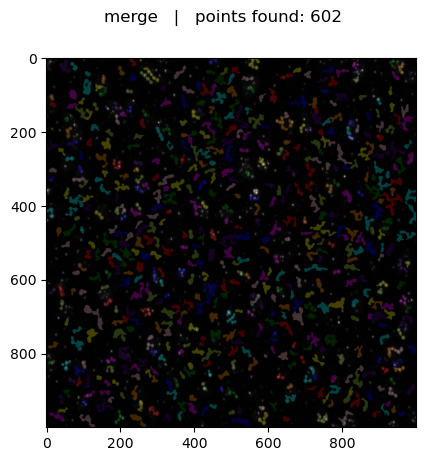

In [5]:
# option 1: threshold segmentation

# get images
images = [
    '../data/selected-tiles/selected-tiles/out_opt_flow_registered_X15_Y3_c01_Atto_425.tif',
    '../data/selected-tiles/selected-tiles/out_opt_flow_registered_X15_Y3_c01_Alexa_488.tif',
    '../data/selected-tiles/selected-tiles/out_opt_flow_registered_X15_Y3_c01_Alexa_568.tif',
    '../data/selected-tiles/selected-tiles/out_opt_flow_registered_X15_Y3_c01_Alexa_647.tif'
]
imgs = [io.imread(image) for image in images]
grayimgs = [io.imread(image, as_gray=True) for image in images]

# merge images
merge = np.sum(imgs, axis=0)
graymerge = np.sum(grayimgs, axis=0)
#io.imshow(merge)

# segment image to create mask
## large parts of this taken from 'count_nuclei_v3()'
graymerge = ski.exposure.rescale_intensity(graymerge)
preproc = ski.filters.gaussian(merge, sigma=2.6, preserve_range=True)       # Gaussian blur reduces heterogeneous intensity in nuclei
preproc = ski.exposure.rescale_intensity(preproc)                           # improves contrast

# subtract background
bg = ski.filters.gaussian(merge, sigma=30)
preproc = preproc - bg
preproc[preproc < 0]  = 0  # make sure there are no negative values
preproc = preproc / np.max(preproc)  # normalize

# segmentation
#threshold = ski.filters.threshold_otsu(preproc)
threshold = ski.filters.threshold_local(preproc, block_size=31, offset=-0.0001)
#threshold = ski.filters.threshold_sauvola(preproc, window_size=51, k=0.0001)  ## improvable segmentation, but captures some detail
#threshold = ski.filters.threshold_niblack(preproc, window_size=31, k=0.0001)
#threshold = threshold*0.7                                                  # reduce threshold for more detailed segmentation
seg = ski.morphology.closing(preproc > threshold, ski.morphology.square(3))
seg = ski.morphology.opening(seg)
#seg = ski.morphology.remove_small_objects(seg, min_size=100)                # remove small objects under min_size pixels

# watershed
distance = ndi.distance_transform_edt(seg)                                  # watershed bw to separate touching nuclei
coords = ski.feature.peak_local_max(distance, footprint=np.ones((4, 4)), labels=seg, min_distance=20)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
wsh = ski.segmentation.watershed(-distance, markers, mask=seg)
wsh = ski.morphology.remove_small_objects(wsh, min_size=150)                # remove small objects under min_size pixels

_, num = ski.measure.label(wsh, return_num=True)                            # label segmented regions

# draw coordinates in plot
#fig, ax = plt.subplots(2, 2, figsize=(10,10))
name = 'merge'
plt.suptitle(name + '   |   points found: ' + str(num))

#plt.subplot(2,2,1)
#plt.imshow(merge)
#plt.subplot(2,2,2)
#plt.imshow(preproc)
#
#plt.subplot(2,2,3)
plt.imshow(ski.color.label2rgb(wsh, graymerge, alpha=0.25, bg_label=0, bg_color=None))

plt.show()

In [7]:
# option 2: machine-learning based sequencing
## did not work, as prediction needs too much memory

import sklearn  # scikit-learn
from sklearn.ensemble import RandomForestClassifier

annotimg = merge          # merge is fetched from above
annotimg[350:360,80:90] = 1     # define background
annotimg[288:290,183:185] = 2   # define foreground
#io.imshow(annotimg)

blurred = ski.filters.gaussian(merge, sigma=2)
edges = ski.filters.sobel(blurred)

feature_stack = [
    merge.ravel(),
    blurred.ravel(),
    edges.ravel()
]
feature_stack = np.asarray(feature_stack)

X = feature_stack.T
y = annotimg.ravel()
mask = y > 0
X = X[mask]
y = y[mask]

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)

# continued below

RandomForestClassifier(max_depth=2, random_state=0)

In [8]:
# continued from above

res = classifier.predict(feature_stack.T) - 1  # subtract 1 to make background 0
io.imshow(res.reshape(merge.shape))

MemoryError: Unable to allocate 48.7 GiB for an array with shape (1000000, 1, 6538) and data type float64

C:\Users\s404923\AppData\Local\Temp\ipykernel_492\817014315.py:25: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  contimg = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)  ## maybe try and use fig.canvas.frombuffer, as .tostring might not work for long
C:\Users\s404923\AppData\Local\Temp\ipykernel_492\817014315.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  contimg = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)  ## maybe try and use fig.canvas.frombuffer, as .tostring might not work for long


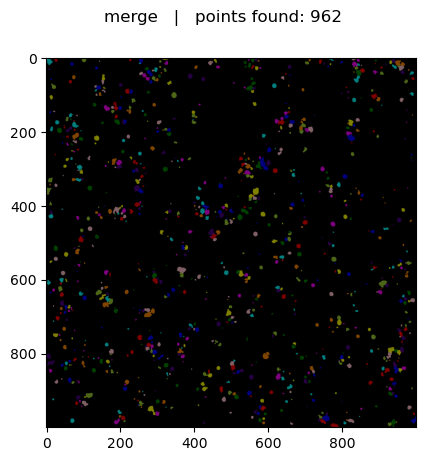

In [62]:
# option 3: contour segmentation
## takes contour plot from 'ax.contour()', binarizes it to use as mask for 'check_expression()'
## worked well, implemented into 'batch_decode_barcodes()' and 'check_expression()'

# make merge image
imgs = []
searchpattern = '../data/selected-tiles/selected-tiles/out_opt_flow_registered_X15_Y3' + '*.tif'
for file in glob.glob(searchpattern):
    if 'DAPI' not in file and 'Atto_490LS' not in file:
        imgs.append(io.imread(file))

merge = np.sum(imgs, axis=0)

# get contour and turn it into an image array
height, width = merge.shape
fig, ax = plt.subplots(figsize=(width/10, height/10), dpi=10, frameon=False)        # change numbers to adjust resolution
qcs = ax.contour(merge, origin='image', levels=11)                                             # qcs contains contour info
ax.set_axis_off()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig.tight_layout(pad=0)
#plt.show()
fig.canvas.draw()
plt.close(fig)

contimg = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)  ## maybe try and use fig.canvas.frombuffer, as .tostring might not work for long
contimg = ski.color.rgb2gray(contimg)
contimg = ski.morphology.opening(contimg)
#io.imshow(contimg, interpolation='none', cmap='gray')

#print('merge shape: ' + str(merge.shape) + '\ncontimg shape: ' + str(contimg.shape))  ## only for testing if merge (original image) and contimg are the same

# binarize contimg to use as mask
#hist, hist_centers = ski.exposure.histogram(contimg)  # draw histogram to choose threshold
#fig, ax = plt.subplots()
#ax.plot(hist_centers, hist, lw=2)

threshold = 0.9  # exact number does not matter, maybe adjust if complications occur
seg = ski.morphology.closing(contimg > threshold, ski.morphology.square(3))
seg = np.invert(seg)
seg = ski.morphology.closing(seg)
#io.imshow(seg)

# watershed
distance = ndi.distance_transform_edt(seg)                                          # watershed bw to separate touching nuclei
coords = ski.feature.peak_local_max(distance, footprint=np.ones((4, 4)), labels=seg, min_distance=7)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
wsh = ski.segmentation.watershed(-distance, markers, mask=seg)
#wsh = ski.morphology.remove_small_objects(wsh, min_size=150)                        # remove small objects under min_size pixels

_, num = ski.measure.label(wsh, return_num=True)

name = 'merge'
plt.suptitle(name + '   |   points found: ' + str(num))
plt.imshow(ski.color.label2rgb(wsh, merge, alpha=0.5, bg_label=0, bg_color=None))

C:\Users\s404923\AppData\Local\Temp\ipykernel_18468\2005136649.py:27: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  contimg = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)  # turn contour plot into image array  ## maybe try and use fig.canvas.frombuffer, as .tostring might not work for long
C:\Users\s404923\AppData\Local\Temp\ipykernel_18468\2005136649.py:27: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  contimg = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)  # turn contour plot into image array  ## maybe try and use fig.canvas.frombuffer, as .tostring might not work for long


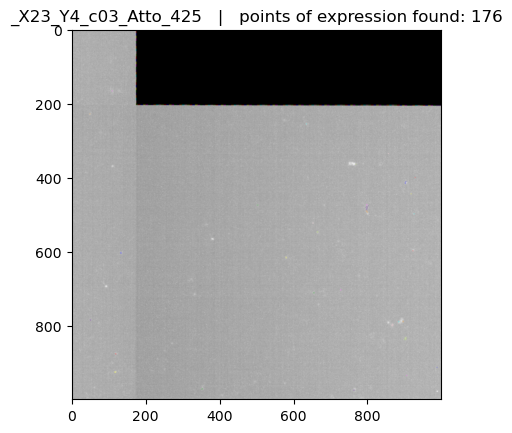

In [27]:
#### testing

image = '../data/selected-tiles/selected-tiles/out_opt_flow_registered_X23_Y4_c03_Atto_425.tif'

img = io.imread(image, dtype=np.float64)
grayimg = io.imread(image, as_gray=True, dtype=np.float64)                          # create image for diagnostic figure
grayimg = ski.exposure.rescale_intensity(grayimg)
#preproc = ski.filters.gaussian(img, sigma=2.5, preserve_range=True)                # Gaussian blur reduces heterogeneous intensity in nuclei
#preproc = ski.exposure.rescale_intensity(img)                                      # improves contrast

name = os.path.basename(image).removeprefix('out_opt_flow_registered').removesuffix('.tif')

if 'Atto_425' in name:       # segment Atto425 stained image
    preproc = ski.exposure.rescale_intensity(img)                                   # improves contrast

    height, width = img.shape                                                       # create contour plot
    fig, ax = plt.subplots(figsize=(width/25, height/25), dpi=25, frameon=False)    # change numbers to adjust resolution  # all numbers must be the same
    #qcs = ax.contour(preproc, origin='image')                                       # qcs contains contour info
    qcs = ax.contour(preproc, origin='image', levels=2)
    ax.set_axis_off()
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout(pad=0)
    #plt.show()
    fig.canvas.draw()
    plt.close(fig)

    contimg = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)  # turn contour plot into image array  ## maybe try and use fig.canvas.frombuffer, as .tostring might not work for long
    contimg = ski.color.rgb2gray(contimg)
    #contimg = ski.morphology.closing(contimg)
    contimg = ski.morphology.opening(contimg)

elif 'merge' in image:        # segment merge image
    img = ski.exposure.rescale_intensity(img)

    height, width = img.shape                                                       # create contour plot
    fig, ax = plt.subplots(figsize=(width/15, height/15), dpi=15, frameon=False)    # change numbers to adjust resolution  # all numbers must be the same
    qcs = ax.contour(img, origin='image', levels=10)                                           # qcs contains contour info
    ax.set_axis_off()
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout(pad=0)
    #plt.show()
    fig.canvas.draw()
    plt.close(fig)

    contimg = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)  # turn contour plot into image array  ## maybe try and use fig.canvas.frombuffer, as .tostring might not work for long
    contimg = ski.color.rgb2gray(contimg)
    #contimg = ski.morphology.closing(contimg)
    contimg = ski.morphology.opening(contimg)

else:                       # segment all other images
    preproc = ski.exposure.rescale_intensity(img)

    height, width = img.shape                                                       # create contour plot
    fig, ax = plt.subplots(figsize=(width/15, height/15), dpi=15, frameon=False)    # change numbers to adjust resolution  # all numbers must be the same
    qcs = ax.contour(preproc, origin='image', levels=7)                                       # qcs contains contour info
    ax.set_axis_off()
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout(pad=0)
    #plt.show()
    fig.canvas.draw()
    plt.close(fig)

    contimg = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)  # turn contour plot into image array  ## maybe try and use fig.canvas.frombuffer, as .tostring might not work for long
    contimg = ski.color.rgb2gray(contimg)
    #contimg = ski.morphology.closing(contimg)
    contimg = ski.morphology.opening(contimg)

threshold = 0.9  # exact number does not matter                                 # segment contour image
seg = ski.morphology.closing(contimg > threshold, ski.morphology.square(3))
seg = np.invert(seg)
seg = ski.morphology.closing(seg)

distance = ndi.distance_transform_edt(seg)                                      # watershed
coords = ski.feature.peak_local_max(distance, footprint=np.ones((4, 4)), labels=seg, min_distance=7)
mask = np.zeros(img.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
wsh = ski.segmentation.watershed(-distance, markers, mask=seg)
#wsh = ski.morphology.remove_small_objects(wsh, min_size=150)  ## removed, not helpful here


_, num = ski.measure.label(wsh, return_num=True)                                # label segmented regions

# draw coordinates in plot
plt.title(name + '   |   points of expression found: ' + str(num))

#wsh = wsh.astype(np.float64)
#grayimg = grayimg.astype(np.float64)
plt.imshow(ski.color.label2rgb(wsh, grayimg, alpha=0.25, bg_label=0, bg_color=None))

c:\Users\s404923\AppData\Local\miniforge3\envs\MyEnv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


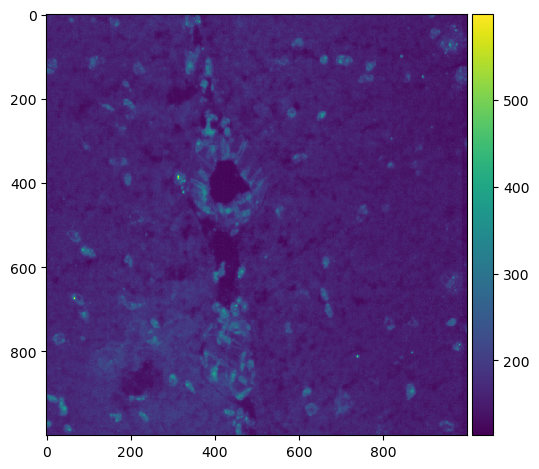

In [43]:
#### testing

image = '../data/selected-tiles/selected-tiles/out_opt_flow_registered_X12_Y12_c03_Atto_425.tif'

img = io.imread(image)

io.imshow(img)

([<matplotlib.patches.Wedge at 0x203dcfcd7d0>,
 [Text(-0.11798960570984439, 1.0936537171081326, 'invalid:\n53 %'),
  Text(-0.8432548034957738, -0.7063436390180804, 'no match:\n15 %'),
  Text(0.6118181367655937, -0.9141545643514982, 'genes:\n34075')])

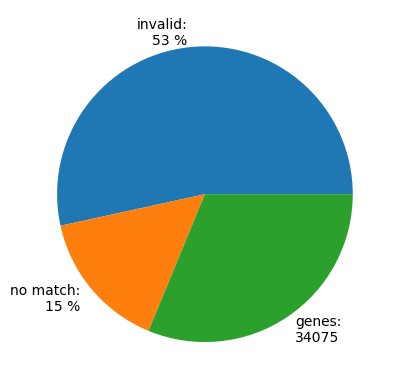

In [3]:
#### testing
# make pie charts to compare results of two groups

groupa = pd.read_csv('../results/Task-15/all-fovs/gene-counts.csv')
groupb = pd.read_csv('../results/Task-15/multiple-fovs/gene-counts.csv')

groupainvalid = groupa[groupa['gene'] == 'invalid']['count'].sum()
groupanomatch = groupa[groupa['gene'] == 'no match']['count'].sum()
groupagenes = groupa[~groupa['gene'].isin(['invalid', 'no match'])]['count'].sum()
groupares = [groupainvalid, groupanomatch, groupagenes]
allgroupa = groupa['count'].sum()

groupbinvalid = groupb[groupb['gene'] == 'invalid']['count'].sum()
groupbnomatch = groupb[groupb['gene'] == 'no match']['count'].sum()
groupbgenes = groupb[~groupb['gene'].isin(['invalid', 'no match'])]['count'].sum()
groupbres = [groupbinvalid, groupbnomatch, groupbgenes]
allgroupb = groupb['count'].sum()

#fig, ax = plt.subplots(1, 2)
#ax[0].pie(groupares, labels=['invalid:\n'+str(int(100/allgroupa*groupainvalid))+' %', 'no match:\n'+str(int(100/allgroupa*groupanomatch))+' %', 'genes:\n'+str(groupagenes)])
#ax[0].set_title('all fovs')
#ax[1].pie(groupbres, labels=['invalid:\n'+str(int(100/allgroupb*groupbinvalid))+' %', 'no match:\n'+str(int(100/allgroupb*groupbnomatch))+' %', 'genes:\n'+str(groupbgenes)])
#ax[1].set_title('fovs 1 and 2')

plt.pie(groupares, labels=['invalid:\n'+str(int(100/allgroupa*groupainvalid))+' %', 'no match:\n'+str(int(100/allgroupa*groupanomatch))+' %', 'genes:\n'+str(int(groupagenes))])